In [5]:
from Dataset import *
import cupy as cp
from bpnn_cuda import BPNN

def convert_categories(y_cat):
    desired = cp.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join("datasets", "face_mask_pickled"), "dataset_gray_conv.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [cp.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")

ntrials = 1
max_epochs = 30
init_nc = [ndimen, 1200, 600, 300, 2]
init_b = 50
init_lr = 1


model_BPNN = BPNN(init_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)

# Loading from Gzip Pickle File: datasets/face_mask_pickled/dataset_gray_conv.pkl.gzip
Input Dimension: 3481
# Training MLP Network: Sizes=[3481, 1200, 600, 300, 2]	Epochs=30	Batch-Size=50	Learning-Rate=1
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:
	1. Correct 486/800	(score: 0.6075	delta: 0.6075	delta_avg: 0.6075)
	2. Correct 538/800	(score: 0.6725	delta: 0.06499999999999995	delta_avg: 0.33625)
	3. Correct 551/800	(score: 0.68875	delta: 0.016249999999999987	delta_avg: 0.22958333333333333)
	4. Correct 482/800	(score: 0.6025	delta: -0.08624999999999994	delta_avg: 0.150625)
	5. Correct 545/800	(score: 0.68125	delta: 0.07874999999999999	delta_avg: 0.13625)
	6. Correct 524/800	(score: 0.655	delta: -0.026249999999999996	delta_avg: 0.10916666666666668)
	7. Correct 503/800	(score: 0.62875	delta: -0.026249999999999996	delta_avg: 0.08982142857142858)
	8. Correct 577/800	(score: 0.72125	delta: 0.09249999999999992	delta_avg: 0.09015625)
	9. Correct 609/800	(score: 0.76125	de

(0.7,
 [0.6075,
  0.6725,
  0.68875,
  0.6025,
  0.68125,
  0.655,
  0.62875,
  0.72125,
  0.76125,
  0.65,
  0.70375,
  0.73,
  0.75625,
  0.66875,
  0.6225,
  0.76125,
  0.7775,
  0.725,
  0.695,
  0.6625,
  0.79,
  0.74875,
  0.76875,
  0.77625,
  0.785,
  0.79125,
  0.75375,
  0.59,
  0.785,
  0.7],
 None,
 310.5903625488281)

Training Epoch vs. Accuracy (Effect of Network Configuration)
# Loading from Gzip Pickle File: datasets/face_mask_pickled/dataset_gray_conv.pkl.gzip


KeyboardInterrupt: 

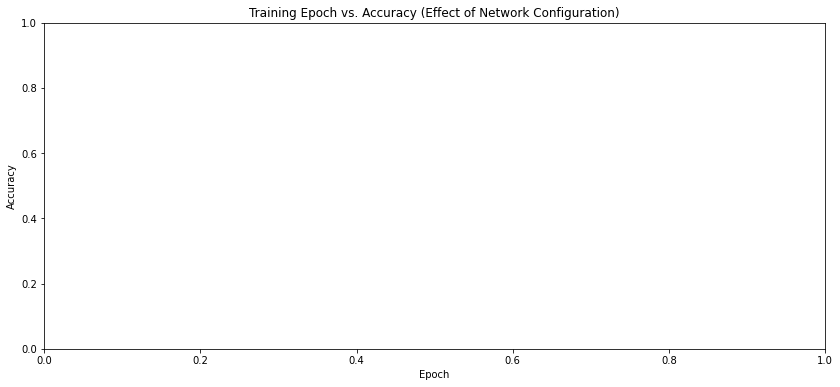

In [6]:
def plot_accuracies_hidden_layers_and_nodes(save_dir, layers_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Network Configuration)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(
        f"Training Epoch vs. Accuracy (Effect of Network Configuration)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for layers in layers_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(layers, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=init_b,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{layers} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = layers
        plt.plot(epoch_scores, label=f'{layers} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_layers_vs_acc', dpi=100)

    return best_config


layers_arr = [[ndimen, 50, 2],
              [ndimen, 100, 2],
              [ndimen, 250, 2],
              [ndimen, 500, 2],
              [ndimen, 1000, 2],
              [ndimen, 1500, 2],
              [ndimen, 2500, 2],
              [ndimen, 3000, 2]]

best_nc = plot_accuracies_hidden_layers_and_nodes("img", layers_arr)

In [ ]:
def plot_accuracies_mini_batch_size(save_dir, batch_size_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Batch Size)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Batch Size)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for batch_size in batch_size_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=batch_size,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{batch_size} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = batch_size
        plt.plot(epoch_scores, label=f'{batch_size} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_batch_vs_acc', dpi=100)

    return best_config


batch_size_arr = [5, 10, 15, 20, 40, 80, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500]
best_b = plot_accuracies_mini_batch_size("img", batch_size_arr)

In [ ]:
def plot_accuracies_learning_rate(save_dir, learning_rate_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for learning_rate in learning_rate_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=best_b,
                                                                               learning_rate=learning_rate,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)

            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{learning_rate} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = learning_rate

        plt.plot(epoch_scores, label=f'{learning_rate} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_lr_vs_acc', dpi=100)

    return best_config


learning_rate_arr = [3, 2, 1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]
best_lr = plot_accuracies_learning_rate("img", learning_rate_arr)

In [ ]:
"""
Plot the convergence curve of BPNN
"""

training_data, validation_data, testing_data, ndimen = get_data()

nn = BPNN(best_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, nn_conv_time = nn.train(training_data,
                                                                      max_epochs=max_epochs,
                                                                      batch_size=best_b,
                                                                      learning_rate=best_lr,
                                                                      evaluation_data=validation_data,
                                                                      evaluation_treshold=None)

fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label='Convergence Curve')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)

acc = 0
acc0 = 0
len0 = 0
acc1 = 0
len1 = 0

for (x, y) in testing_data:
    decision = np.argmax(nn.feedforward(x))

    if decision == y:
        acc += 1
    if y == 0:
        len0 += 1
        if decision == y:
            acc0 += 1
    if y == 1:
        len1 += 1
        if decision == y:
            acc1 += 1

nn_acc = acc / (len0 + len1)
# Compute class accuracies
nn_acc0 = acc0 / len0
nn_acc1 = acc1 / len1

print(f'Overall Testing Accuracy: {nn_acc}')
print(f'Class 0 Testing Accuracy: {nn_acc0}')
print(f'Class 1 Testing Accuracy: {nn_acc1}')
